In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.serif'] = ['KaiTi']

In [2]:
#导入数据
train_abbr=pd.read_csv("datalab/231702/happiness_train_abbr.csv",encoding='ISO-8859-1')
train=pd.read_csv("datalab/231702/happiness_train_complete.csv",encoding='ISO-8859-1')
test_abbr=pd.read_csv("datalab/231702/happiness_test_abbr.csv",encoding='ISO-8859-1')
test=pd.read_csv("datalab/231702/happiness_test_complete.csv",encoding='ISO-8859-1')
test_sub=pd.read_csv("datalab/231702/happiness_submit.csv",encoding='ISO-8859-1')

In [3]:
#观察数据大小
test.shape

(2968, 139)

In [4]:
test_sub.shape

(2968, 2)

In [5]:
train.shape

(8000, 140)

In [6]:
#简单查看数据
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50


In [7]:
# 检查是否有缺失值
def checkingMissing(df):
    miss = df.isnull().sum().any()
    if miss:
        total_miss = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total_miss, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dType =str(df[col].dtype)
            data_type.append(dType)
        output['Types'] = data_type
        print(output[output['Total'] != 0])
        return np.transpose(output)
    else:
        return False
checkingMissing(train)

                 Total   Percent    Types
edu_other         7997  0.009996   object
edu_status        1120  0.001400  float64
edu_yr            1972  0.002465  float64
join_party        7176  0.008970  float64
property_other    7934  0.009917   object
hukou_loc            4  0.000005  float64
social_neighbor    796  0.000995  float64
social_friend      796  0.000995  float64
work_status       5049  0.006311  float64
work_yr           5049  0.006311  float64
work_type         5049  0.006311  float64
work_manage       5049  0.006311  float64
family_income        1  0.000001  float64
invest_other      7971  0.009964   object
minor_child       1066  0.001332  float64
marital_1st        828  0.001035  float64
s_birth           1718  0.002148  float64
marital_now       1770  0.002213  float64
s_edu             1718  0.002148  float64
s_political       1718  0.002148  float64
s_hukou           1718  0.002148  float64
s_income          1718  0.002148  float64
s_work_exper      1718  0.002148  

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,7997,1120,1972,0,0,7176,0,0,0,0,0,0,0,0,0,0,7934,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,796,796,0,0,0,0,0,0,0,5049,5049,5049,5049,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,7971,0,0,1066,0,828,1718,1770,1718,1718,1718,1718,1718,5435,5435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00999625,0.0014,0.002465,0,0,0.00897,0,0,0,0,0,0,0,0,0,0,0.0099175,0,0,0,0,0,0,5e-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000995,0.000995,0,0,0,0,0,0,0,0.00631125,0.00631125,0.00631125,0.00631125,0,0,0,0,1.25e-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00996375,0,0,0.0013325,0,0.001035,0.0021475,0.0022125,0.0021475,0.0021475,0.0021475,0.0021475,0.0021475,0.00679375,0.00679375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,int64,int64,object,float64,float64,int64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64


In [8]:
#查看label分布
yTrain_=train["happiness"]
yTrain_.value_counts()

 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [9]:
#将-8换成3（填充数据3代表幸福也不幸福）
yTrain_=yTrain_.map(lambda x:3 if x==-8 else x)


In [10]:
#让label从0开始
yTrain_=yTrain_.map(lambda x:x-1)

In [11]:
# 显示数据的统计量，均值、标准差、最小值、分位数、最大值
train.describe()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,6880.000000,6028.000000,8.000000e+03,8000.000000,824.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,7996.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,7204.000000,7204.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,2951.000000,2951.000000,2951.000000,2951.000000,8000.000000,8000.000000,8000.000000,8000.000000,7.999000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.0,8000.000000,8000.000000,8000.000000,8000.000000,6934.000000,8000.000000,7172.000000,6282.000000,6230.000000,6282.000000,6282.000000,6282.000000,6.282000e+03,6282.000000,2565.000000,2565.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000
mean,4000.50000,3.850125,1.405500,15.155375,42.564750,70.619000,1.53000,1964.707625,1.37350,0.772250,1.427250,4.878375,3.505523,1574.742867,3.330734e+04,1.317750,1785.067961,115.302954,0.007875,0.473000,0.268500,0.101125,0.102750,0.023625,0.004000,0.022500,0.13600,163.989750,121.575625,3.598500,3.786250,3.819375,1.893750,1.375938,1.891875,1.710125,1.797375,3.915375,2.368625,1.60575,1.625250,4.496500,3.452375,3.762125,4.402625,3.756250,3.554000,3.591500,3.521500,4.713500,4.482125,3.427375,2.790625,3.291000,1.92650,3.474181,3.622432,1.825500,3.135125,4.192250,3.439625,4.445125,2.925375,2.979750,3.155202,14.500508,0.906811,2.652321,1.062125,1.232875,1.820875,1.835625,6.776050e+04,2.882500,2.595875,1.063625,1.817125,0.014875,0.909500,0.06150,0.020750,0.004750,0.001875,0.0,0.000750,0.000750,0.924375,0.767125,0.456879,3.234375,1825.481177,1963.963069,1868.025522,4.614454,1.319007,1.842566,2.836550e+04,2.838427,3.175828,0.963743,1108.42025,2.043500,1.079125,2.744625,1150.667250,1.550500,0.89900

In [12]:
#train和test连在一起
allData = pd.concat([train,test],axis=0,ignore_index=True,sort=False)

In [13]:
# 家庭收入与幸福指数的pearson相关系数，相关性不大
train['happiness'].corr(train['family_income'].astype(float), method='pearson')

0.047654140221694105

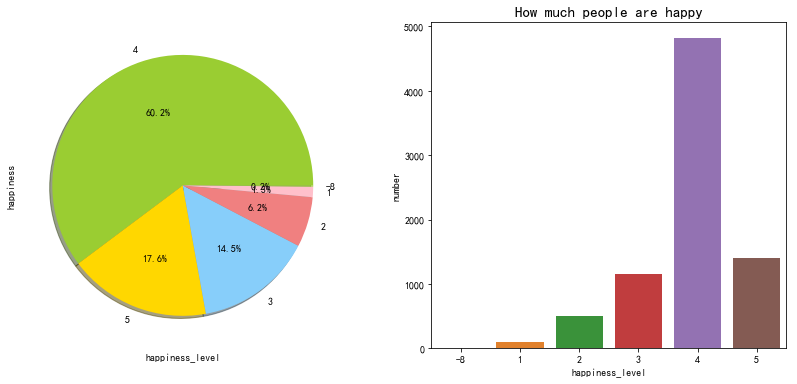

In [14]:
# 5个等级幸福感的柱状图，5个等级的占比图
f,ax=plt.subplots(1,2,figsize=(14,6))
# 部分分离开
#explode = (0.05,0.05,0,0,0)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','pink']
train['happiness'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True,colors=colors)
ax[0].set_xlabel('happiness_level')
# 用seaborn的计数图
sns.countplot('happiness',data=train,ax=ax[1])
# ax[1] = train['happiness'].value_counts().plot.bar()
ax[1].set_title('How much people are happy',fontsize=15)
ax[1].set_xlabel('happiness_level')
ax[1].set_ylabel('number')
plt.show()

In [15]:
## 分性别分析,1男，2女
train.groupby(['gender', 'happiness'])['happiness'].count()

gender  happiness
1       -8              8
         1             43
         2            216
         3            588
         4           2306
         5            599
2       -8              4
         1             61
         2            281
         3            571
         4           2512
         5            811
Name: happiness, dtype: int64

Text(0.5, 0.98, 'The proportion of happiness level in differenr gender')

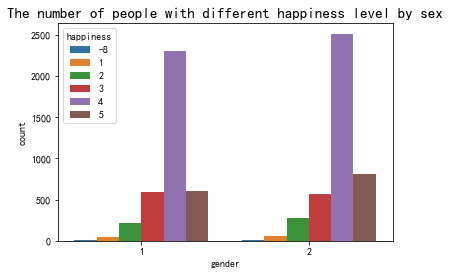

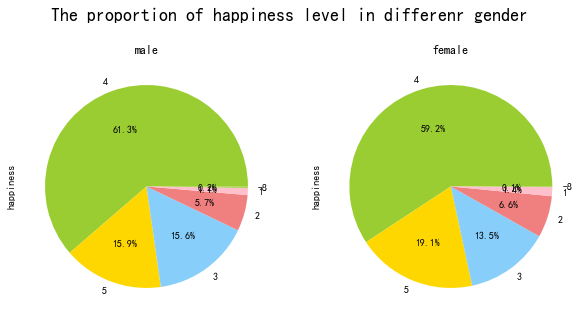

In [16]:
# 男女的幸福指数比较
# hue为色彩色度的意思，可以理解为hue决定具有多彩的标签
sns.countplot(x='gender', hue='happiness', data=train)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','pink']
plt.title('The number of people with different happiness level by sex',fontsize=15)
# 在男性女性中，5个happiness level所占比例pie图
fig,ax1 = plt.subplots(1,2,figsize=(10,5))
# 部分分离开
#explode = (0.05,0.03,0,0,0)
train['happiness'][train['gender']==1].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1[0], title='male',colors=colors)
train['happiness'][train['gender']==2].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1[1], title='female',colors=colors)
fig.suptitle('The proportion of happiness level in differenr gender', fontsize=18, verticalalignment='center')

Text(0.5, 0.98, 'The number of people with different happiness level by sample type')

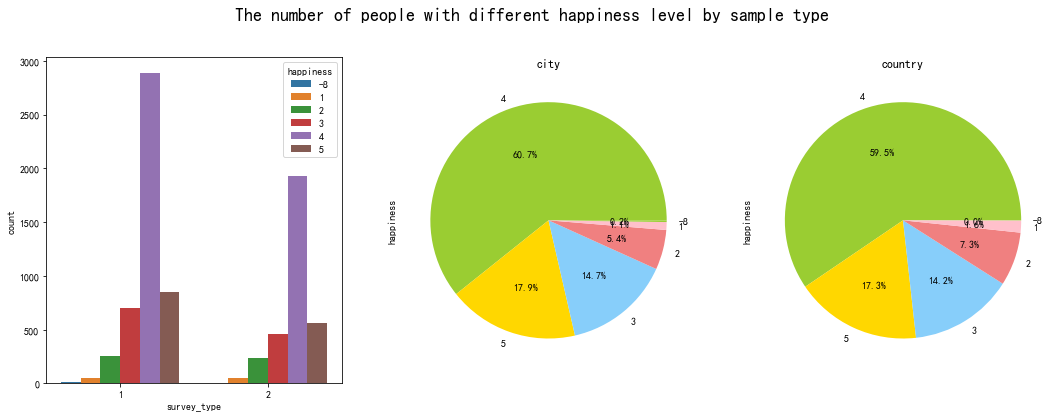

In [17]:
# 样本类型的幸福指数比较，1表示城市，2表示农村
f,ax=plt.subplots(1,3,figsize=(18,6))
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','pink']
sns.countplot(x='survey_type', hue='happiness', data=train, ax=ax[0])
# 在样本类型中，5个happiness level所占比例pie图
#explode = (0.05,0.03,0,0,0)
train['happiness'][train['survey_type']==1].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1] ,title='city',colors=colors)
train['happiness'][train['survey_type']==2].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[2] ,title='country',colors=colors)
f.suptitle('The number of people with different happiness level by sample type', fontsize=18, verticalalignment='center')

Text(0.5, 0.98, 'The proportion of happiness level in differenr equity')

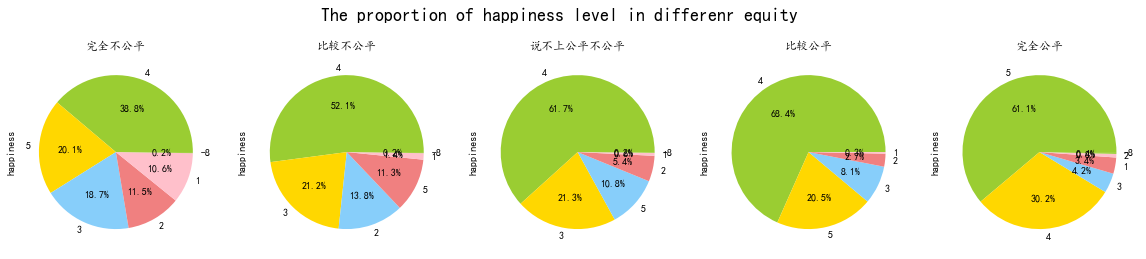

In [18]:
# 在社会公平5个阶段中，5个happiness level所占比例pie图
fig,ax1 = plt.subplots(1,5,figsize=(20,4))
#explode = (0.05,0.03,0,0,0)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','pink']
train['happiness'][train['equity']==1].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1[0], title='完全不公平',colors=colors)
train['happiness'][train['equity']==2].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1[1], title='比较不公平',colors=colors)
train['happiness'][train['equity']==3].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1[2], title='说不上公平不公平',colors=colors)
train['happiness'][train['equity']==4].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1[3], title='比较公平',colors=colors)
train['happiness'][train['equity']==5].value_counts().plot.pie(autopct='%1.1f%%', ax=ax1[4], title='完全公平',colors=colors)
fig.suptitle('The proportion of happiness level in differenr equity', fontsize=18, verticalalignment='center')

In [19]:
#全部数据大小
allData.shape

(10968, 140)

In [20]:
# 查看房屋面积分布
floorArea=allData["floor_area"]
floorArea=floorArea.map(lambda x:100 if x>1000  else x)

In [21]:
#处理时间特征
allData['survey_time'] = pd.to_datetime(allData['survey_time'],format='%Y-%m-%d %H:%M:%S')
allData["weekday"]=allData["survey_time"].dt.weekday
allData["year"]=allData["survey_time"].dt.year
allData["quarter"]=allData["survey_time"].dt.quarter
allData["hour"]=allData["survey_time"].dt.hour
allData["month"]=allData["survey_time"].dt.month

In [22]:
#把一天的时间分段
def hourCut(x):
    if 0<=x<6:
        return 0
    elif  6<=x<8:
        return 1
    elif  8<=x<12:
        return 2
    elif  12<=x<14:
        return 3
    elif  14<=x<18:
        return 4
    elif  18<=x<21:
        return 5
    elif  21<=x<24:
        return 6

    
allData["hour_cut"]=allData["hour"].map(hourCut)

In [23]:
#做问卷时候的年龄
convertValues=list(train.describe().columns)
allData["survey_age"]=allData["survey_time"]-allData["birth"]
convertValues.remove('birth')
convertValues.append('survey_age')
allData["f_age"]=allData["survey_time"]-allData["f_birth"]
convertValues.remove('f_birth')
convertValues.append('f_age')

In [24]:
#让label从0开始
allData["happiness"]=allData["happiness"].map(lambda x:x-1)
allData['gender'] = allData['gender'].map(lambda x:x-1)

In [25]:
#去掉三个缺失值很多的

allData= allData.drop(columns=["id","happiness","survey_time","edu_other","property_other","invest_other"],axis=1)

In [26]:
#是否入党
allData["join_party"]=allData["join_party"].map(lambda x:0 if pd.isnull(x)  else 1)

In [27]:
#出生的年代
def birthSplit(x):
    if 1920<=x<=1930:
        return 0
    elif  1930<x<=1940:
        return 1
    elif  1940<x<=1950:
        return 2
    elif  1950<x<=1960:
        return 3
    elif  1960<x<=1970:
        return 4
    elif  1970<x<=1980:
        return 5
    elif  1980<x<=1990:
        return 6
    elif  1990<x<=2000:
        return 7
    
allData["birth_s"]=allData["birth"].map(birthSplit)



In [28]:
#收入分组
def incomeCut(x):
    if x<=0:
        return 0
    elif  0<x<=1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<=30000:
        return 3
    elif  30000<x<=40000:
        return 4
    elif  40000<x:
        return 5
    
allData["income_cut"]=allData["income"].map(incomeCut)


# 家庭收入分组
def familyIncomeCut(x):
    if x<=10000:
        return 0
    elif 10000<x<=20000:
        return 1
    elif 20000<x<=40000:
        return 2
    elif  40000<x<=60000:
        return 3
    elif  60000<x<=80000:
        return 4
    elif  80000<x:
        return 5
 

    

#身高分组
def heightCut(x):
    if x<=160:
        return 0
    elif 160<x<=170:
        return 1
    elif 170<x<=180:
        return 2
    elif 180<x<=190:
        return 3
    elif 190<x<=200:
        return 4
    elif  200<x:
        return 0
 

    
allData["height_cm"]=allData["height_cm"].map(heightCut)



def sIncomeCut(x):
    if x<=0 or pd.isnull(x)==1:
        return 2
    elif  0<x<=5000:
        return 3
    elif  5000<x<=10000:
        return 1
    elif  10000<x<=40000:
        return 2
    elif  40000<x<=100000:
        return 3
    elif  100000<x:
        return 4
allData["s_income"]=allData["s_income"].map(sIncomeCut)


def incExpCut(x):
    if x<=0 or pd.isnull(x)==1:
        return 0
    elif  0<x<=5000:
        return 1
    elif  5000<x<=10000:
        return 2
    elif  10000<x<=30000:
        return 3
    elif  30000<x<100000:
        return 4
    elif  100000<x<=300000:
        return 5
    elif  300000<x<=1000000:
        return 6
    elif  1000000<x:
        return 7    
allData["inc_exp"]=allData["inc_exp"].map(incExpCut)


#转换收入变量
allData["inc_exp"]=allData["inc_exp"].map(familyIncomeCut)


In [29]:
allData['marital_1stbir'] = allData['marital_1st'] - allData['birth']#第一次结婚年龄
#最近结婚年龄
allData['marital_nowtbir'] = allData['marital_now'] - allData['birth'] 
#是否再婚
allData['mar'] = allData['marital_nowtbir'] - allData['marital_1stbir']
#配偶年龄
allData['marital_sbir'] = allData['marital_now']-allData['s_birth']
#配偶年龄差
allData['age_'] = allData['marital_nowtbir'] - allData['marital_sbir'] 

   

In [30]:
# 填充数据
allData["edu_status"]=allData["edu_status"].fillna(5)
allData["edu_yr"]=allData["edu_yr"].fillna(-2)
# allData["property_other"]=allData["property_other"].map(lambda x:0 if pd.isnull(x)  else 1)
allData["hukou_loc"]=allData["hukou_loc"].fillna(1)
allData["social_neighbor"]=allData["social_neighbor"].fillna(8)
allData["social_friend"]=allData["social_friend"].fillna(8)
allData["work_status"]=allData["work_status"].fillna(0)
allData["work_yr"]=allData["work_yr"].fillna(0)
allData["work_type"]=allData["work_type"].fillna(0)
allData["work_manage"]=allData["work_manage"].fillna(0)
allData["income_cut"]=allData["income_cut"].fillna(2)
allData["family_income"]=allData["family_income"].fillna(-2)

In [31]:
#填充数据
allData["minor_child"]=allData["minor_child"].fillna(0)
allData["marital_1st"]=allData["marital_1st"].fillna(0)
allData["s_birth"]=allData["s_birth"].fillna(0)
allData["marital_now"]=allData["marital_now"].fillna(0)
allData["s_edu"]=allData["s_edu"].fillna(0)
allData["s_political"]=allData["s_political"].fillna(0)
allData["s_hukou"]=allData["s_hukou"].fillna(0)
allData["s_income"]=allData["s_income"].fillna(0)
allData["s_work_exper"]=allData["s_work_exper"].fillna(0)
allData["s_work_status"]=allData["s_work_status"].fillna(0)
allData["s_work_type"]=allData["s_work_type"].fillna(0)

In [32]:
allData.loc[allData['nationality']<0,'nationality'] = 1

In [33]:
allData[['province','city','nationality','gender']]=allData[['province','city','nationality','gender']].applymap(lambda x:str(x))
dum = pd.get_dummies(allData[['province','city','nationality','gender']])
allData = allData.join(dum)

In [34]:
allData.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10968 entries, 0 to 10967
Data columns (total 272 columns):
survey_type             10968 non-null int64
province                10968 non-null object
city                    10968 non-null object
county                  10968 non-null int64
gender                  10968 non-null object
birth                   10968 non-null int64
nationality             10968 non-null object
religion                10968 non-null int64
religion_freq           10968 non-null int64
edu                     10968 non-null int64
edu_status              10968 non-null float64
edu_yr                  10968 non-null float64
income                  10968 non-null int64
political               10968 non-null int64
join_party              10968 non-null int64
floor_area              10968 non-null float64
property_0              10968 non-null int64
property_1              10968 non-null int64
property_2              10968 non-null int64
property_3              1

In [35]:
xTrain_ = allData[:train.shape[0]]
xTest_  = allData[train.shape[0]:]

In [36]:
targetColumn = 'happiness'
featureColumns = list(xTest_.columns) 
featureColumns

['survey_type',
 'province',
 'city',
 'county',
 'gender',
 'birth',
 'nationality',
 'religion',
 'religion_freq',
 'edu',
 'edu_status',
 'edu_yr',
 'income',
 'political',
 'join_party',
 'floor_area',
 'property_0',
 'property_1',
 'property_2',
 'property_3',
 'property_4',
 'property_5',
 'property_6',
 'property_7',
 'property_8',
 'height_cm',
 'weight_jin',
 'health',
 'health_problem',
 'depression',
 'hukou',
 'hukou_loc',
 'media_1',
 'media_2',
 'media_3',
 'media_4',
 'media_5',
 'media_6',
 'leisure_1',
 'leisure_2',
 'leisure_3',
 'leisure_4',
 'leisure_5',
 'leisure_6',
 'leisure_7',
 'leisure_8',
 'leisure_9',
 'leisure_10',
 'leisure_11',
 'leisure_12',
 'socialize',
 'relax',
 'learn',
 'social_neighbor',
 'social_friend',
 'socia_outing',
 'equity',
 'class',
 'class_10_before',
 'class_10_after',
 'class_14',
 'work_exper',
 'work_status',
 'work_yr',
 'work_type',
 'work_manage',
 'insur_1',
 'insur_2',
 'insur_3',
 'insur_4',
 'family_income',
 'family_m',
 'fa

In [37]:
xTrain = np.array(xTrain_)
yTrain = np.array(yTrain_)
xTest  = np.array(xTest_)


In [38]:
xTrain.shape

(8000, 272)

In [39]:
yTrain.shape

(8000,)

In [40]:
xTest.shape

(2968, 272)

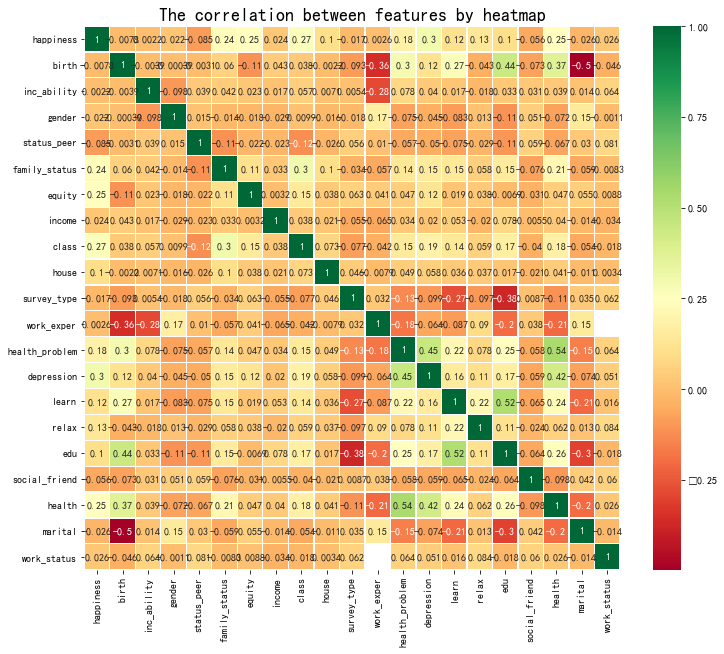

In [41]:
# 绘制热图，热图的用途: seaborn中的heatmap热力图可以得到数据表里多个特征两两的相关度（pearson相关系数计算的）
#外界层面（物质）：birth，inc_ability，gender，status_peer，family_status，equity，class，income，house，survey_type，
#个人层面（精神）：health，work_exper，health_problem，depression，learn，relax，edu，social_friend,marital,work_status
sns.heatmap(train[['happiness','birth','inc_ability','gender','status_peer','family_status','equity','income','class','house','survey_type',
                   'work_exper','health_problem','depression','learn','relax','edu','social_friend','health','marital','work_status']].corr(),
            annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf() # 获取当前的figure
fig.set_size_inches(12,10) # 设置尺寸
plt.title('The correlation between features by heatmap',fontsize=18)
plt.show()

In [42]:
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

In [44]:
##### lgb

param = {'boosting_type': 'gbdt',
         'num_leaves': 20,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth':6,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         
         "feature_fraction": 0.72,
         "bagging_freq": 1,
         "bagging_fraction": 0.6,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.085,
         "verbosity": -1}
folds = KFold(n_splits=6, shuffle=True, random_state=2048)
oof_lgb = np.zeros(len(xTrain_))
predictions_lgb = np.zeros(len(xTest_))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(xTrain, yTrain)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(xTrain[trn_idx], yTrain[trn_idx])
    
    val_data = lgb.Dataset(xTrain[val_idx], yTrain[val_idx])

    num_round = 8000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(xTrain[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(xTest, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, yTrain_)))

fold n°1
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.445447	valid_1's l2: 0.421961
[400]	training's l2: 0.382213	valid_1's l2: 0.397739
[600]	training's l2: 0.344458	valid_1's l2: 0.390302
[800]	training's l2: 0.316006	valid_1's l2: 0.387039
[1000]	training's l2: 0.291784	valid_1's l2: 0.386365
Early stopping, best iteration is:
[922]	training's l2: 0.300727	valid_1's l2: 0.386112
fold n°2
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.435581	valid_1's l2: 0.471634
[400]	training's l2: 0.372701	valid_1's l2: 0.450446
[600]	training's l2: 0.336538	valid_1's l2: 0.443677
[800]	training's l2: 0.309115	valid_1's l2: 0.439712
[1000]	training's l2: 0.28531	valid_1's l2: 0.43813
[1200]	training's l2: 0.265266	valid_1's l2: 0.437903
Early stopping, best iteration is:
[1100]	training's l2: 0.275137	valid_1's l2: 0.437548
fold n°3
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.435

In [45]:
# ##### xgb

xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 
               'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(xTrain, yTrain)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(xTrain[trn_idx], yTrain[trn_idx])
    val_data = xgb.DMatrix(xTrain[val_idx], yTrain[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(xTrain[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(xTest), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, yTrain_)))

fold n°1
[0]	train-rmse:2.49566	valid_data-rmse:2.48122	train-myFeval:6.22832	valid_data-myFeval:6.15647
Multiple eval metrics have been passed: 'valid_data-myFeval' will be used for early stopping.

Will train until valid_data-myFeval hasn't improved in 200 rounds.
[100]	train-rmse:1.61254	valid_data-rmse:1.60363	train-myFeval:2.60028	valid_data-myFeval:2.57163
[200]	train-rmse:1.11428	valid_data-rmse:1.11484	train-myFeval:1.24163	valid_data-myFeval:1.24286
[300]	train-rmse:0.850496	valid_data-rmse:0.865109	train-myFeval:0.723343	valid_data-myFeval:0.748414
[400]	train-rmse:0.719498	valid_data-rmse:0.750424	train-myFeval:0.517677	valid_data-myFeval:0.563136
[500]	train-rmse:0.656006	valid_data-rmse:0.702136	train-myFeval:0.430344	valid_data-myFeval:0.492995
[600]	train-rmse:0.623088	valid_data-rmse:0.681857	train-myFeval:0.388238	valid_data-myFeval:0.464929
[700]	train-rmse:0.603553	valid_data-rmse:0.673676	train-myFeval:0.364277	valid_data-myFeval:0.453839
[800]	train-rmse:0.589635	v

In [46]:
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
kfolder = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_cb = np.zeros(len(xTrain_))
predictions_cb = np.zeros(len(xTest_))
kfold = kfolder.split(xTrain_, yTrain_)
fold_=0
#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = xTrain[train_index]
    k_y_train = yTrain[train_index]
    k_x_vali = xTrain[vali_index]
    k_y_vali = yTrain[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 5,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(xTest_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits



print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, yTrain_)))

fold n°0
0:	learn: 0.8178464	test: 0.7822124	best: 0.7822124 (0)	total: 77.8ms	remaining: 2h 9m 41s
100:	learn: 0.6716606	test: 0.6745807	best: 0.6745807 (100)	total: 1.34s	remaining: 22m 8s
200:	learn: 0.6422434	test: 0.6678107	best: 0.6678107 (200)	total: 2.71s	remaining: 22m 23s
300:	learn: 0.6144204	test: 0.6648333	best: 0.6644101 (283)	total: 4.02s	remaining: 22m 10s
400:	learn: 0.5917312	test: 0.6637532	best: 0.6636008 (398)	total: 5.35s	remaining: 22m 9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6636008313
bestIteration = 398

Shrink model to first 399 iterations.
fold n°1
0:	learn: 0.8103520	test: 0.8159872	best: 0.8159872 (0)	total: 11.1ms	remaining: 18m 31s
100:	learn: 0.6715865	test: 0.6801108	best: 0.6801108 (100)	total: 968ms	remaining: 15m 57s
200:	learn: 0.6414826	test: 0.6689757	best: 0.6689757 (200)	total: 1.77s	remaining: 14m 36s
300:	learn: 0.6147126	test: 0.6645776	best: 0.6645776 (300)	total: 2.33s	remaining: 12m 50s
400:	learn: 0.5923606	

In [47]:
from sklearn import linear_model
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()


folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2018)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,yTrain)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], yTrain[trn_idx]
    val_data, val_y = train_stack[val_idx], yTrain[val_idx]
    
    clf_3 = linear_model.BayesianRidge()
    #clf_3 =linear_model.Ridge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_stack, yTrain_)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.44929489


In [49]:
from sklearn.preprocessing import StandardScaler
result=list(predictions_lgb)
result=list(map(lambda x: x + 1, result))
stand = StandardScaler()
stand.fit(xTrain);
result=list(map(lambda x:2 if 3.452<=x<3.453 or 3.158<=x<3.159  else x,result))
# L_reg = LogisticRegression(C=0.5,penalty='l2',multi_class="multinomial", solver="newton-cg")
result=list(map(lambda x:5 if 3.50094<=x<3.50095 or 3.3815<=x<3.3816 else x,result))
# L_reg = LogisticRegression(C=0.5,penalty='l2',multi_class="multinomial", solver="newton-cg")
# scores = cross_val_score(L_reg,data_train,data_happiness,cv=3)
result=list(map(lambda x:3 if 4.202606<=x<4.202607 else x,result))
xTrain = stand.transform(xTrain)
# w = [1.0*i/k for i in range(k+1)]

C:\Users\BGM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\BGM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [50]:
#import pandas as pd
# w = data.describe(percentiles = w)[4:4+k+1]
# w[0] = w[0]*(1-1e-10)
result=list(map(lambda x:1.3 if 1.9<=x<=2.1 else x,result))
xTest = stand.transform(xTest)
result=list(map(lambda x:2 if 1.3<=x<1.7 else x,result))
# d2 = pd.cut(data, w, labels = range(k),duplicates='drop')
test_sub["happiness"]=result
test_sub.to_csv("jun112.csv", index=False)

C:\Users\BGM\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
